### Poetry generation using 'Teacher Forcing' Algorithm

In [0]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

In [0]:
# config variables
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 5000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [0]:
# loading in the data
input_texts = []
target_texts = []
for line in open('robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue
  input_line = '<sos> '+line
  target_line = line+' <eos>'
  
  input_texts.append(input_line)
  target_texts.append(target_line)  

In [0]:
all_lines = input_texts + target_texts

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [8]:
# finding max_seq_len
max_seq_len = max(len(s) for s in input_sequences)
print('Max Sequences length:',max_seq_len)

Max Sequences length: 12


In [9]:
word2idx = tokenizer.word_index
print('Found %s unique tokens'%len(word2idx))
print(word2idx['<sos>'])
print(word2idx['<eos>'])

Found 3056 unique tokens
1
2


In [10]:
# padding seq to get a NxT matrix
max_seq_len = min(max_seq_len, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='post')
output_sequences = pad_sequences(target_sequences, maxlen=max_seq_len, padding='post')
print('Shape of data tensor:',input_sequences.shape)

Shape of data tensor: (1436, 12)


In [11]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-08-09 12:22:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-09 12:22:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-09 12:22:47--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [12]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [13]:
# loading pre-trained word vectors
word2vec = {}
with open('glove.6B.%sd.txt'%EMBEDDING_DIM) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors:'%len(word2vec))

# preparing embedding matrix
num_words = min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i<MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Found 400000 word vectors:


In [0]:
# one-hot the targets
one_hot_targets = np.zeros((len(input_sequences), max_seq_len, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i,t,word] = 1

In [0]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],trainable=False)

In [0]:
print('Building the model')

input_ = Input(shape=(max_seq_len,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x,_,_ = lstm(x, initial_state=[initial_h, initial_c])
dense = Dense(num_words, activation='softmax')
output = dense(x)

In [0]:
model = Model([input_, initial_h, initial_c], output)
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy'])

In [0]:
print('Training the model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit([input_sequences,z,z],
              one_hot_targets,batch_size=BATCH_SIZE,
              epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

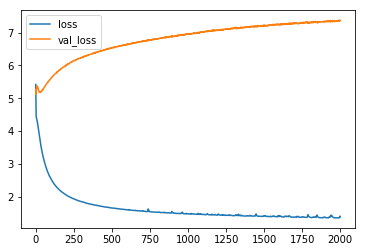

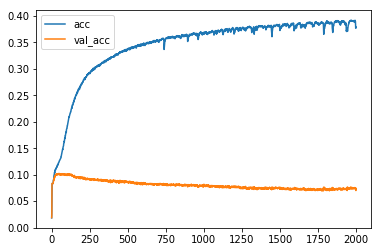

In [19]:
#plotting the results
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'],label='acc')
plt.plot(r.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

In [0]:
# make a sampling model for prediction
input2 = Input(shape=(1,)) # we only input one word at a time
# using the trained layers
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c])
output2 = dense(x)
sampling_model = Model([input2,initial_h,initial_c], [output2,h,c])

In [0]:
idx2word = {v:k for k,v in word2idx.items()}

In [0]:
def sample_line():
  np_input = np.array([[word2idx['<sos>']]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))
  
  eos = word2idx['<eos>']
  
  output_sentence = []
  
  for _ in range(max_seq_len):
    o,h,c = sampling_model.predict([np_input,h,c])
    probs = o[0,0]
    probs[0] = 0
    probs/=probs.sum()
    idx = np.random.choice(len(probs),p=probs)
    if idx == eos:
      break
    output_sentence.append(idx2word.get(idx))
    np_input[0,0] = idx
  return ' '.join(output_sentence)

In [27]:
for _ in range(4):
  print(sample_line())

of in going twice around the bed,
she would last winter dwelling in the cold to the passing car
a hole off away from trees,
it's hoping the poetess's the voices. this was,
